In [14]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [15]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [16]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [17]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [18]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [19]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

In [20]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("EI:",ei)

Lower bound is [ 2.4616976  -0.15820762  0.6115967  -1.59247998  0.73172675  0.59479032]
Upper bound is [ 2.61558693  0.          0.77040062 -1.44729294  0.8994239   0.76480859]
pdf upper is [0.01927558 0.3939807  0.33089182 0.11226033 0.30524195 0.33426329]
cdf upper is [0.99308594 0.4371466  0.72959769 0.05563845 0.76783232 0.72400818]
pdf lower is [0.01304193 0.39894228 0.29650325 0.13997843 0.2662232  0.29777872]
cdf lower is [0.99554629 0.5        0.77946886 0.07390745 0.81578654 0.77780723]
EI: [0.45912329 0.         0.42896999 1.27966822 0.58813728 0.38385797]


In [21]:
#Test calc_ei_adv (to compare with hand calcs)
import numpy as np
import torch
er_best = 1.0
mu = torch.tensor([3])
y_exp2 = np.array([4])
pred_var = torch.tensor([1])
print("EI:",calc_ei_advanced(er_best,mu,pred_var,y_exp2))

Lower bound is [0.]
Upper bound is [2.]
pdf upper is [0.39894228]
cdf upper is [0.5]
pdf lower is [0.05399097]
cdf lower is [0.97724987]
EI: [0.79259589]


Improvement is [-5.2035183e-05]


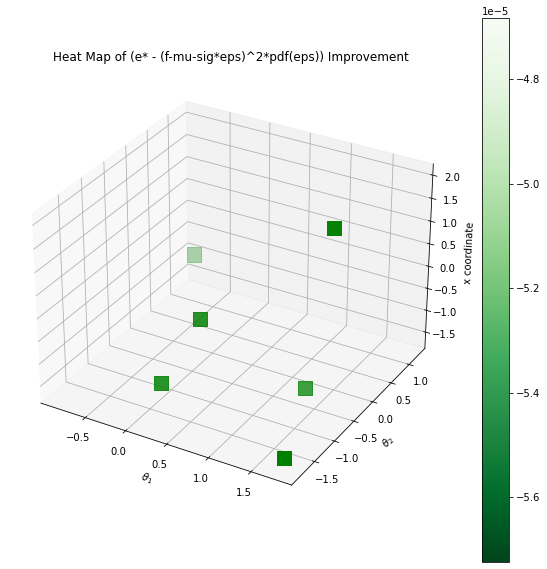

None


In [22]:
eps = -5
I = improvement(er_best,mu,pred_var,y_exp2,eps)
print("Improvement is", I)
print(improvement_plot(test_p,I))

Improvement: [array([-5.2035183e-05]), array([-0.00475064]), array([-0.11176728]), array([-0.60791585]), array([-0.48540264]), array([0.27435801]), array([0.05526508]), array([-0.01819467]), array([-0.00152379]), array([-2.23007927e-05])]


Text(0, 0.5, 'Improvement')

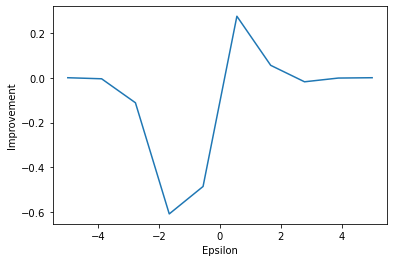

In [23]:
EPS = np.linspace(-5,5,10)
I_test = []
for i in range(len(EPS)):
    I_i = I = improvement(er_best,mu,pred_var,y_exp2,EPS[i])
    I_test.append(I_i)
print("Improvement:", I_test) 

from matplotlib import pyplot as plt    
plt.plot(EPS,I_test)
plt.xlabel("Epsilon")
plt.ylabel("Improvement")

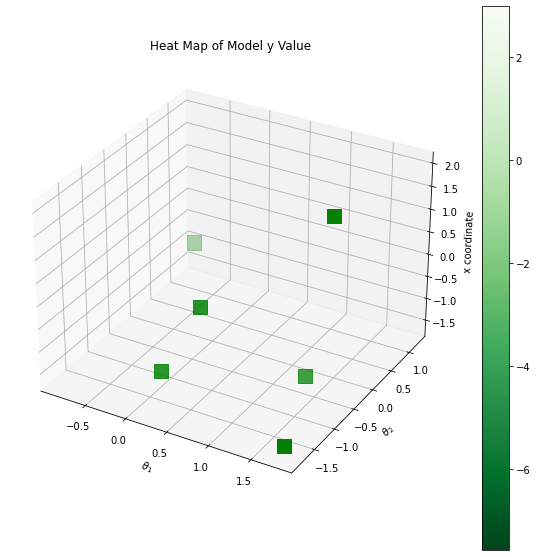

None


In [24]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

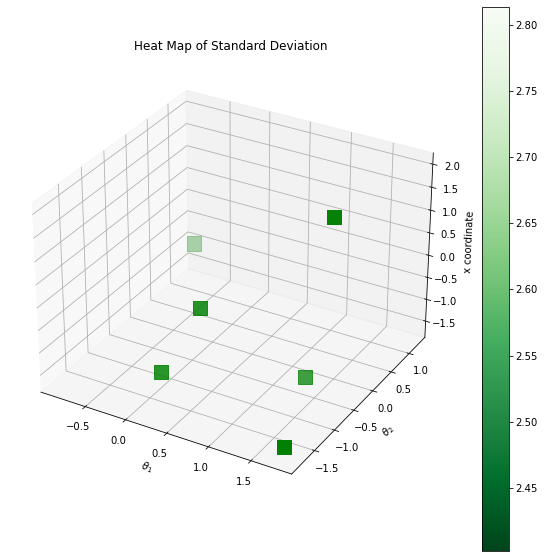

None


In [25]:
print(stdev_plotter_adv(test_p, model_stdev))

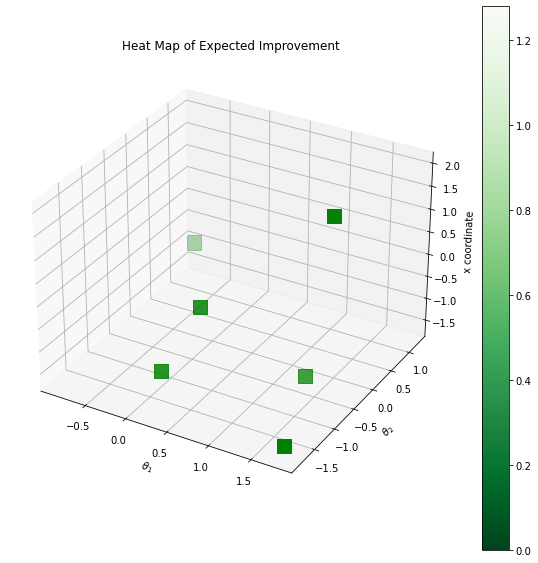

None


In [26]:
print(ei_plotter_adv(test_p, ei))